# 3 - Plotting fields in Tokamak geometry

In this tutorial we will learn how to plot FEEC data in poloidal planes of a Tokamak geometry. 

The Struphy run generating the data for this tutorial can be launched via:

    $ struphy test tutorials -n 3
    
All data generated in this way is stored in the Struphy installation path (obtained from ``struphy -p``) under ``io/out/tutorial_03``.

## Time, logical and physical grids

Let us start by inspecting the content of the `post_processing/` folder, see [Tutorial 2](https://struphy.pages.mpcdf.de/struphy/doc/_build/html/tutorials/tutorial_02_postproc_standard_plotting.html):

In [100]:
import os
import struphy

path_out = os.path.join(struphy.__path__[0], 'io/out/', 'sim_Stokes_10steps')   #_10x10_10steps
data_path = os.path.join(path_out, 'post_processing')
fluid_path = os.path.join(data_path, 'fields_data' )

Since this was a run of the model `LinearMHD`, only `fields_data/` is present in the output. Let us get the time grid,

In [101]:
import numpy as np

t_grid = np.load(os.path.join(data_path, 't_grid.npy'))


The simulation was done in `Tokamak` geometry with a resolution of `[8, 32, 4]`. In any toroidal geometry in Struphy, poloidal planes are always parametrized by the first two coordinates $(\eta_1, \eta_2)$ (here with a resolution `[8, 32]`), where $\eta_1$ parametrizes the radial coordinate and $\eta_2$ the angle coordinate. The toroidal angle is always parametrized by $\eta_3$ (here with a resolution of `[4]`). 

Moreover, we spot an MHD initial condition of type `TorusModesSin`, where the second (poloidal-angle) component of the MHD velocity `u2` is initialized in logical coordinates with a poloidal mode number $m=3$, toroidal mode number $n=1$ and an amlitude 0.001. The radial profile is given by a half-period `sin` function (zero at the edges).

Let us first load the logical 1d grid vectors:

In [102]:
import pickle
with open(os.path.join(fluid_path, 'grids_phy.bin'), 'rb') as file:
    x_grid, y_grid, z_grid = pickle.load(file)
    
with open(os.path.join(fluid_path, 'grids_log.bin'), 'rb') as file:
    e1_grid, e2_grid, e3_grid = pickle.load(file)
    

The physical grids are already stored as meshgrids, because they are not product grids.

In a Tokamak, we need to compute the $R$- and $\phi$-grids from the physical grid (please check out the [Struphy domain documentation](https://struphy.pages.mpcdf.de/struphy/sections/domains.html) for more details on the definition of the specific mappings). In Struphy, we have the convention that the **poloidal angle goes counter-clock-wise** (at toroidal $\phi = 0$) and the **toroidal angle goes clock-wise** when viewed from the top. 

The mapping $F_2: (R, Z, \phi) \mapsto (x, y, z)$ is thus given by
$$
\begin{aligned}
 x &= R \cos(\phi) \\
 y &= -R\sin(\phi) \\
 z &= Z
 \end{aligned}
$$

The Jacobian and its inverse are given by
$$
 DF_2 = \begin{pmatrix}
 \cos(\phi) & 0 & - R \sin(\phi)
 \\
 -\sin(\phi) & 0 & - R \cos(\phi) 
 \\
 0 & 1 & 0 
 \end{pmatrix}\,,\qquad
 DF_2^{-1} = \begin{pmatrix}
 \cos(\phi) & - \sin(\phi) & 0
 \\
 0 & 0 & 1
 \\
 -\frac 1R \sin(\phi) & - \frac 1R \cos(\phi) & 0
 \end{pmatrix}\,.
$$
The Jacobian determinant and metric tensor read
$$
 \textnormal{det} DF_2 = R\,,\qquad G = \begin{pmatrix}
 1 & 0 & 0
 \\
 0 &  1 & 0
 \\
 0 & 0 & R^2
 \end{pmatrix}\,.
$$


We must pay attention to the parameter `tor_period` of the [Tokamak](https://struphy.pages.mpcdf.de/struphy/sections/domains.html#struphy.geometry.domains.Tokamak) geometry, which was set to 3, meaning that only one third of the total Torus has been simulated, $\phi \in (0, 2\pi/3)$.

In [103]:
R_grid = np.sqrt(x_grid**2 + y_grid**2)
phi_grid = np.arctan2(-y_grid, x_grid)

#print(f'{max(R_grid[:,:,0]) = }')
# print(f'{min(R_grid) = }')
# print(f'{max(phi_grid) = }')
# print(f'{min(phi_grid) = }')

for n in range(phi_grid.shape[2]):
    print(phi_grid[0, 0, n])
    
print('check: 2pi/3 = ', 2*np.pi/3)

print('Shape of the R-grid:', R_grid.shape)
print('Shape of the phi-grid:', phi_grid.shape)
print('Shape of the z-grid:', z_grid.shape)

0.0
-2.4492935982947064e-16
check: 2pi/3 =  2.0943951023931953
Shape of the R-grid: (17, 17, 2)
Shape of the phi-grid: (17, 17, 2)
Shape of the z-grid: (17, 17, 2)


Moreover, we can plot the vector components in different coordinates. For instance, let us plot $u^*_R$, i.e. the R-component of the vector field in $(R, Z, \phi)$-cooridnates, denoted with a star.

 For this we need to pullback the physical $(x, y, z)$-components of $u$ to $(R, Z, \phi)$-space. The pullback is given by the inverse Jacobian,
$$
 u^* = DF_2^{-1} u\,.
$$

For the first ($R$-)component this means
$$
 u^*_R = \cos(\phi) u_x - \sin(\phi) u_y\,,
$$
For the second ($\phi$-)component this means
$$
 u^*_\phi = u_z \,,
$$
For the third ($Z$-)component this means
$$
 u^*_Z =  -\frac{1}{R}\sin(\phi) u_x -\frac{1}{R} \cos(\phi) u_y .
$$

We now load the values of $u$ in the physical domain:

In [104]:
with open(os.path.join(fluid_path, 'mhd/', 'u_phy.bin'), 'rb') as file:
    u_phy = pickle.load(file)
    
with open(os.path.join(fluid_path, 'mhd/', 'ue_phy.bin'), 'rb') as file:
    ue_phy = pickle.load(file)
    
with open(os.path.join(fluid_path, 'mhd/', 'potential_phy.bin'), 'rb') as file:
    potential_phy = pickle.load(file)


## Analytic solution

In [105]:
# Analytic solution from Paper Restelli
uanalyt0 = 0.1/2*R_grid*(-z_grid)+2.5/R_grid*z_grid
uanalyt1 = 0.1/2*R_grid*(R_grid-2)+2.5/R_grid*(-(R_grid-2))
uanalyt2 = 2.5/R_grid*(10/12.5)
uanalyt = [uanalyt0, uanalyt1, uanalyt2]
potential_analytical = [0.5*(((R_grid-2)**2+z_grid**2)-2/3)]

## Transformation of $xyz$ solution to $R  Z \phi$

In [106]:
u_phy_RZphi = {}
ue_phy_RZphi = {}
for n, (t, u_comps) in enumerate(u_phy.items()):     
    # ion velocity u_RZphi
    u_phy_R = u_comps[0]*np.cos(phi_grid) - u_comps[1]*np.sin(phi_grid)
    u_phy_Z = u_comps[2] 
    u_phy_phi = -1/R_grid*u_comps[0]*np.sin(phi_grid) - 1/R_grid*u_comps[1]* np.cos(phi_grid)
    u_phy_RZphi[t] = [u_phy_R, u_phy_Z, u_phy_phi]

for n, (t, u_comps) in enumerate(ue_phy.items()):    
    # electron velocity ue_RZphi
    ue_phy_R = u_comps[0]*np.cos(phi_grid) - u_comps[1]*np.sin(phi_grid)
    ue_phy_Z = u_comps[2]
    ue_phy_phi = -1/R_grid*u_comps[0]*np.sin(phi_grid) - 1/R_grid*u_comps[1]* np.cos(phi_grid)
    ue_phy_RZphi[t] = [ue_phy_R, ue_phy_Z, ue_phy_phi]
    

(1.0100505063388328,
 2.9899494936611677,
 -0.9899494936611669,
 0.9899494936611669)

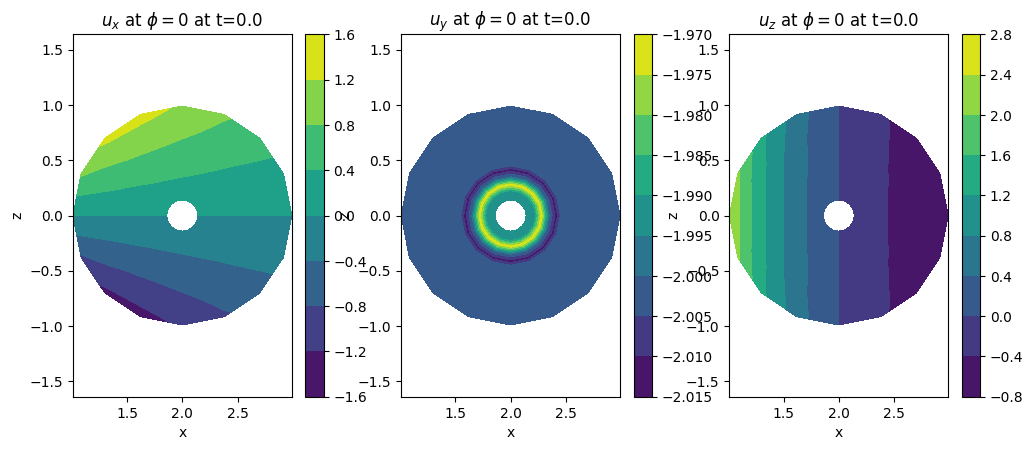

In [107]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 16))
#u_analyt
plt.subplot(3, 3, 1)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], u_phy[0.0][0][:, :, 0])
plt.colorbar()
plt.title(f'$u_x$ at $\phi=0$ at t=0.0')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

# u_xyz
plt.subplot(3, 3, 2)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], u_phy[0.0][1][:, :, 0])
plt.colorbar()
plt.title(f'$u_y$ at $\phi=0$ at t=0.0')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

# u_RZphi
plt.subplot(3, 3, 3)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], u_phy[0.0][2][:, :, 0])
plt.colorbar()
plt.title(f'$u_z$ at $\phi=0$ at t=0.0')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

(1.0100505063388328,
 2.9899494936611677,
 -0.9899494936611669,
 0.9899494936611669)

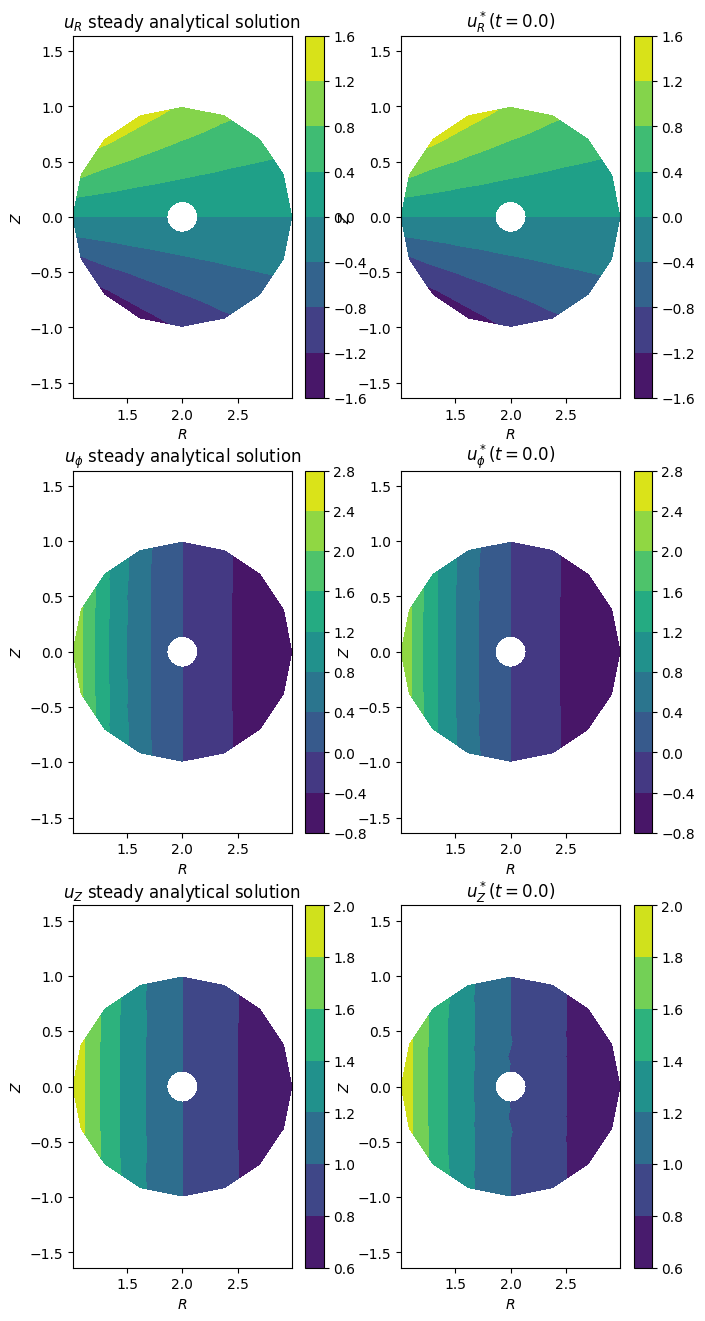

In [108]:
### ion velocity u

plt.figure(figsize=(12, 16))

plt.subplot(3, 3, 1)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[0][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_R$ steady analytical solution')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 3, 2)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], u_phy_RZphi[0.0][0][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u^*_R(t=0.0)$')
plt.colorbar()
plt.axis('equal')
# plt.subplot(3, 3, 3)
# plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], phy_u_phy[0.0][0][:, :, 0])
# plt.xlabel('$R$')
# plt.ylabel('$Z$')
# plt.title(f'$u^*_R(t=0.0)$ [phy, phy, phy]')
# plt.colorbar()
# plt.axis('equal')

plt.subplot(3, 3, 4)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[1][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_\phi$ steady analytical solution')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 3, 5)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], u_phy_RZphi[0.0][1][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u^*_\phi(t=0.0)$')
plt.colorbar()
plt.axis('equal')
# plt.subplot(3, 3, 6)
# plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], phy_u_phy_RZphi[0.0][1][:, :, 0])
# plt.xlabel('$R$')
# plt.ylabel('$Z$')
# plt.title(f'$u^*_\phi(t=0.0)$ [phy, phy, phy]')
# plt.colorbar()
# plt.axis('equal')

plt.subplot(3, 3, 7)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[2][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_Z$ steady analytical solution')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 3, 8)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], u_phy_RZphi[0.0][2][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u^*_Z(t=0.0)$')
plt.colorbar()
plt.axis('equal')
# plt.subplot(3, 3, 9)
# plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], phy_u_phy_RZphi[0.0][2][:, :, 0])
# plt.xlabel('$R$')
# plt.ylabel('$Z$')
# plt.title(f'$u^*_Z(t=0.0)$ [phy, phy, phy]')
# plt.colorbar()
# plt.axis('equal')



In [109]:
print(u_phy_RZphi[0.0][2].min())
print(u_phy_RZphi[0.0][2].max())
print(uanalyt[2].min())
print(uanalyt[2].max())

0.6689364508851717
1.9801843472811937
0.6689076200919425
1.9800990024246152


(1.0100505063388328,
 2.9899494936611677,
 -0.9899494936611669,
 0.9899494936611669)

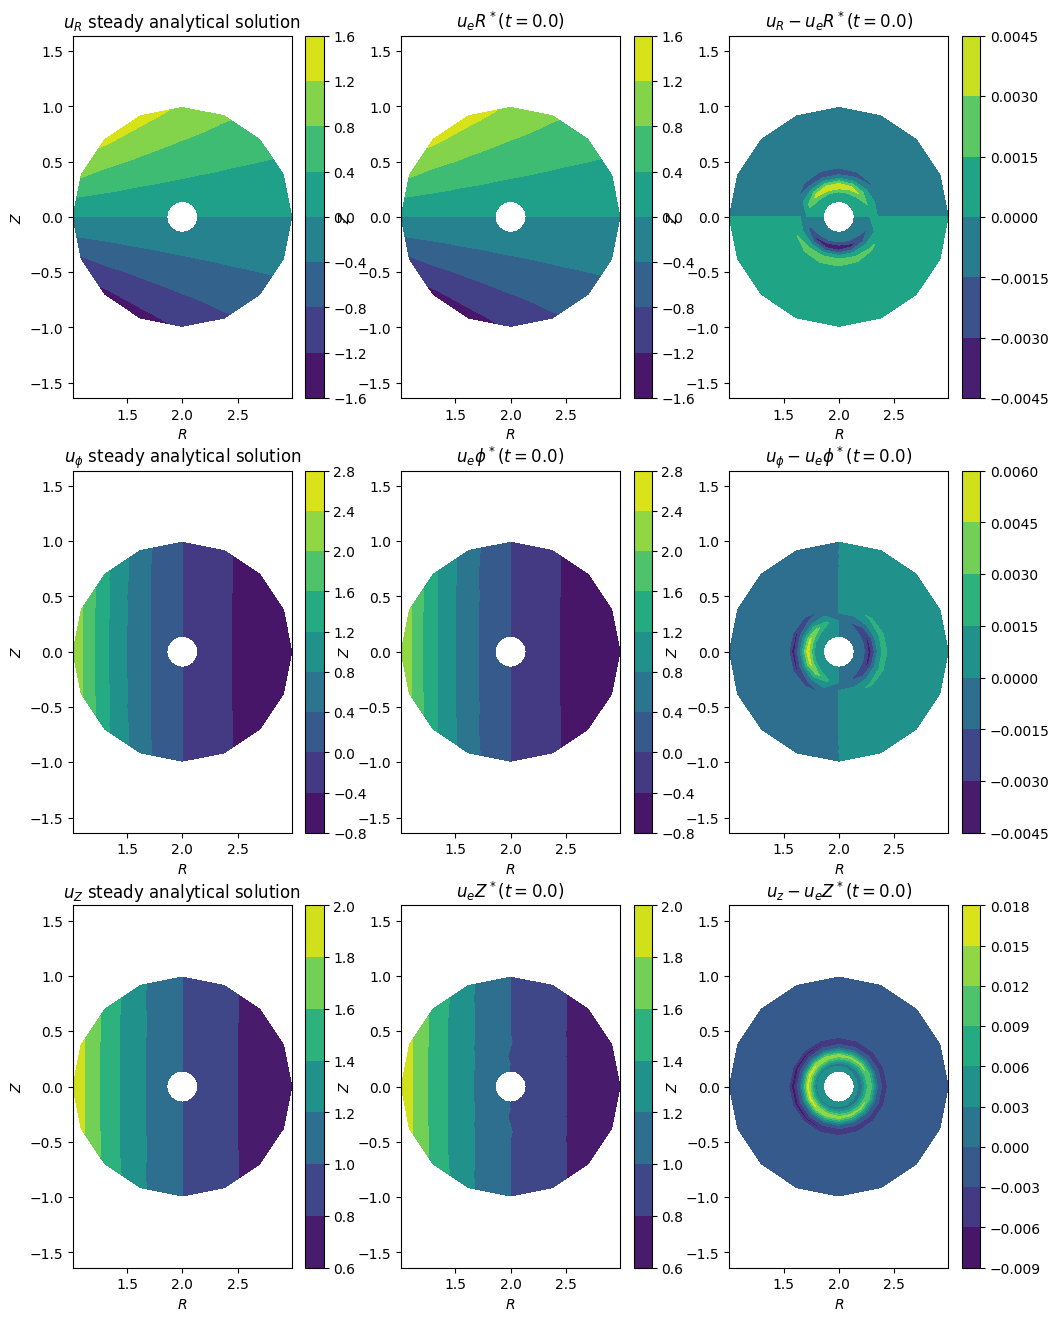

In [110]:
### electron velocity ue

plt.figure(figsize=(12, 16))

plt.subplot(3, 3, 1)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[0][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_R$ steady analytical solution')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 3, 2)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], ue_phy_RZphi[0.0][0][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_eR^*(t=0.0)$')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 3, 3)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[0][:, :, 0]-ue_phy_RZphi[0.0][0][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_R-u_eR^*(t=0.0)$')
plt.colorbar()
plt.axis('equal')

plt.subplot(3, 3, 4)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[1][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_\phi$ steady analytical solution')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 3, 5)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], ue_phy_RZphi[0.0][1][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_e\phi^*(t=0.0)$')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 3, 6)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[1][:, :, 0]-ue_phy_RZphi[0.0][1][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_\phi - u_e\phi^* (t=0.0)$')
plt.colorbar()
plt.axis('equal')

plt.subplot(3, 3, 7)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[2][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_Z$ steady analytical solution')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 3, 8)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], ue_phy_RZphi[0.0][2][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_eZ^*(t=0.0)$')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 3, 9)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[2][:, :, 0]-ue_phy_RZphi[0.0][2][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u_z - u_eZ^*(t=0.0)$')
plt.colorbar()
plt.axis('equal')

We can also show the vector field $(u^*_R, u^*_Z)$ in the poiloidal $(R,Z)$-plane:

(17, 17)
(17, 17)
(17, 17)
(17, 17)


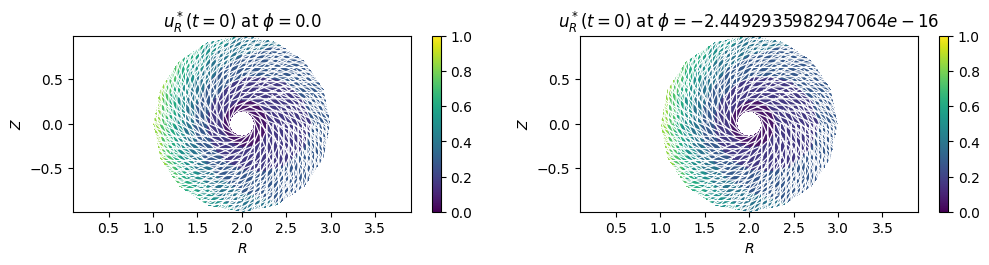

In [111]:
u_phy_init = u_phy[0.0]
n_poloidal_planes = e3_grid.size

plt.figure(figsize=(12, 16))
for n in range(n_poloidal_planes):
    
    uR = np.cos(phi_grid[:, :, n]) * u_phy_init[0][:, :, n] - np.sin(phi_grid[:, :, n]) * u_phy_init[1][:, :, n]
    uZ = u_phy_init[2][:, :, n]
    
    print(uR.shape)
    print(uZ.shape)
    
    plt.subplot(6, 2, n + 1)
    plt.contourf(R_grid[:, :, n], z_grid[:, :, n], np.sqrt(uR**2 + uZ**2))
    plt.quiver(R_grid[:, :, n], z_grid[:, :, n], uR, uZ, scale=.03, color='w')
    plt.xlabel('$R$')
    plt.ylabel('$Z$')
    plt.title(f'$u^*_R(t=0)$ at $\phi={phi_grid[0, 0, n]}$')
    plt.colorbar()
    plt.axis('equal')

## Potential

(1.0100505063388328,
 2.9899494936611677,
 -0.9899494936611669,
 0.9899494936611669)

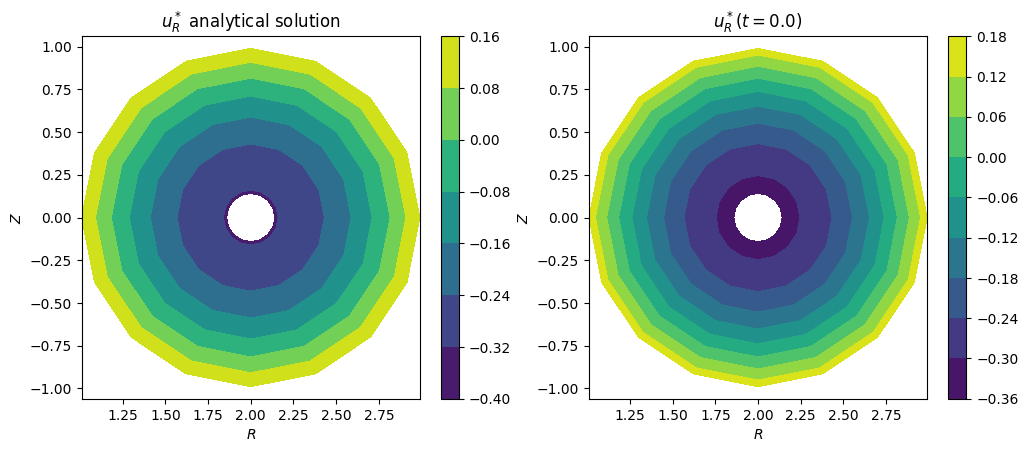

In [112]:
### Potential

plt.figure(figsize=(12, 16))

plt.subplot(3, 2, 1)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], potential_analytical[0][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u^*_R$ analytical solution')
plt.colorbar()
plt.axis('equal')
plt.subplot(3, 2, 2)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], potential_phy[0.0][0][:, :, 0])
plt.xlabel('$R$')
plt.ylabel('$Z$')
plt.title(f'$u^*_R(t=0.0)$')
plt.colorbar()
plt.axis('equal')


## Time evolution
Comparison velocity in xyz with velocity in Rz $\phi$

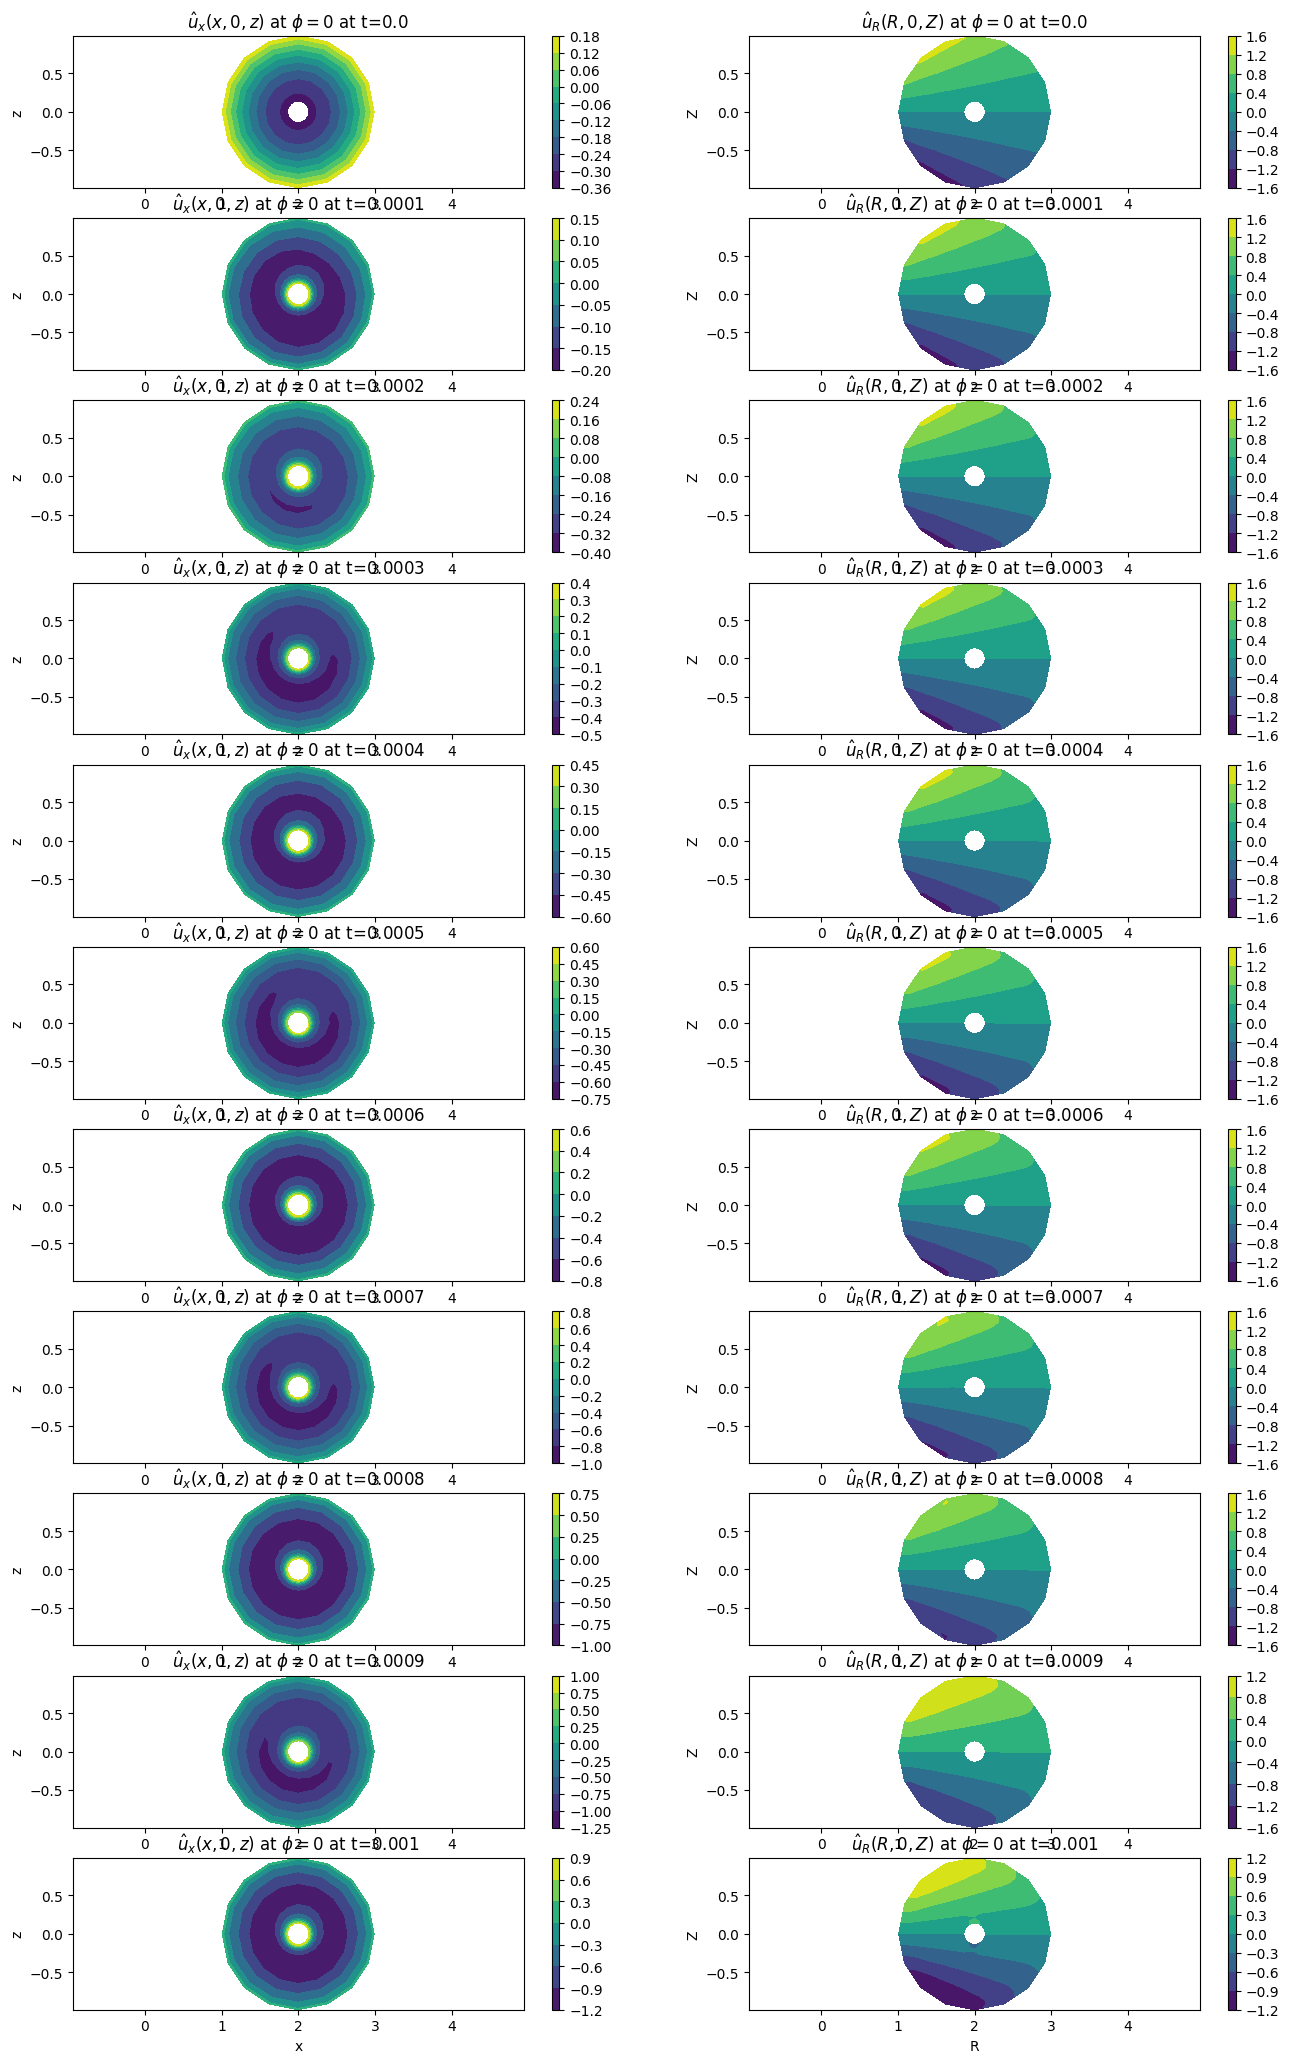

In [113]:
if len(u_phy)>= 1000: 
    plt.figure(figsize=(32, 55))
    for n, (t, u_comps) in enumerate(u_phy.items()): 
        # u_xyz
        if n%100 == 0:
            plt.subplot(12, 2, 2*n//100+1)
            plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], u_comps[0][:, :, 0])
            plt.colorbar()
            plt.title(f'$\hat u_x(x, 0, z)$ at $\phi=0$ at t={t}')
            plt.xlabel('x')
            plt.ylabel('z')
            plt.axis('equal')
            
            #u_RZphi
            plt.subplot(12, 2, 2*n//100+2)
            plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], u_phy_RZphi[t][0][:, :, 0])
            plt.colorbar()
            plt.title(f'$\hat u_R(R, 0, Z)$ at $\phi=0$ at t={t}')
            plt.xlabel('R')
            plt.ylabel('Z')
            plt.axis('equal')
        
elif len(u_phy)>=100:
    plt.figure(figsize=(32, 55))
    for n, (t, u_comps) in enumerate(u_phy.items()): 
        # u_xyz
        if n%10 == 0:
            plt.subplot(12, 2, 2*n//10+1)
            plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], u_comps[0][:, :, 0])
            plt.colorbar()
            plt.title(f'$\hat u_x(x, 0, z)$ at $\phi=0$ at t={t}')
            plt.xlabel('x')
            plt.ylabel('z')
            plt.axis('equal')
            
            #u_RZphi
            plt.subplot(12, 2, 2*n//10+2)
            plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], u_phy_RZphi[t][0][:, :, 0])
            plt.colorbar()
            plt.title(f'$\hat u_R(R, 0, Z)$ at $\phi=0$ at t={t}')
            plt.xlabel('R')
            plt.ylabel('Z')
            plt.axis('equal')
        
else:
    plt.figure(figsize=(16, 28))
    for n, (t, u_comps) in enumerate(potential_phy.items()): 
        # u_xyz
        plt.subplot(12, 2, 2*n+1)
        plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], u_comps[0][:, :, 0])
        plt.colorbar()
        plt.title(f'$\hat u_x(x, 0, z)$ at $\phi=0$ at t={t}')
        plt.xlabel('x')
        plt.ylabel('z')
        plt.axis('equal')
        
        #u_RZphi
        plt.subplot(12, 2, 2*n+2)
        plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], u_phy_RZphi[t][0][:, :, 0])
        plt.colorbar()
        plt.title(f'$\hat u_R(R, 0, Z)$ at $\phi=0$ at t={t}')
        plt.xlabel('R')
        plt.ylabel('Z')
        plt.axis('equal')
        

            
    

(1.0100505063388328,
 2.9899494936611677,
 -0.9899494936611669,
 0.9899494936611669)

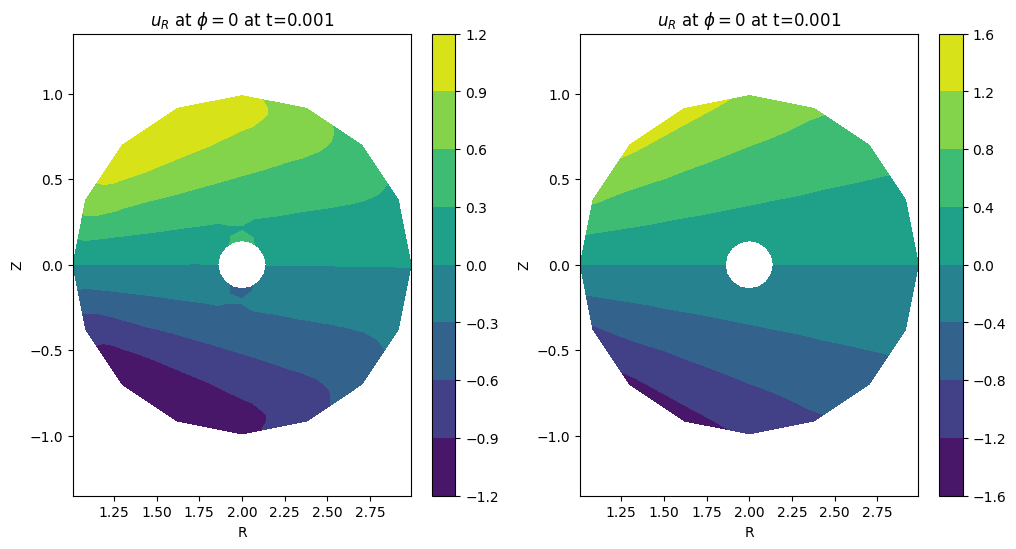

In [115]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], u_phy_RZphi[0.001][0][:, :, 0])
plt.colorbar()
plt.title(f'$u_R$ at $\phi=0$ at t={t}')
plt.xlabel('R')
plt.ylabel('Z')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[0][:, :, 0])
plt.colorbar()
plt.title(f'$u_R$ at $\phi=0$ at t={t}')
plt.xlabel('R')
plt.ylabel('Z')
plt.axis('equal')
        

## Forceterm

comparison of manually and implemented version

(1.0100505063388328,
 2.9899494936611677,
 -0.9899494936611669,
 0.9899494936611669)

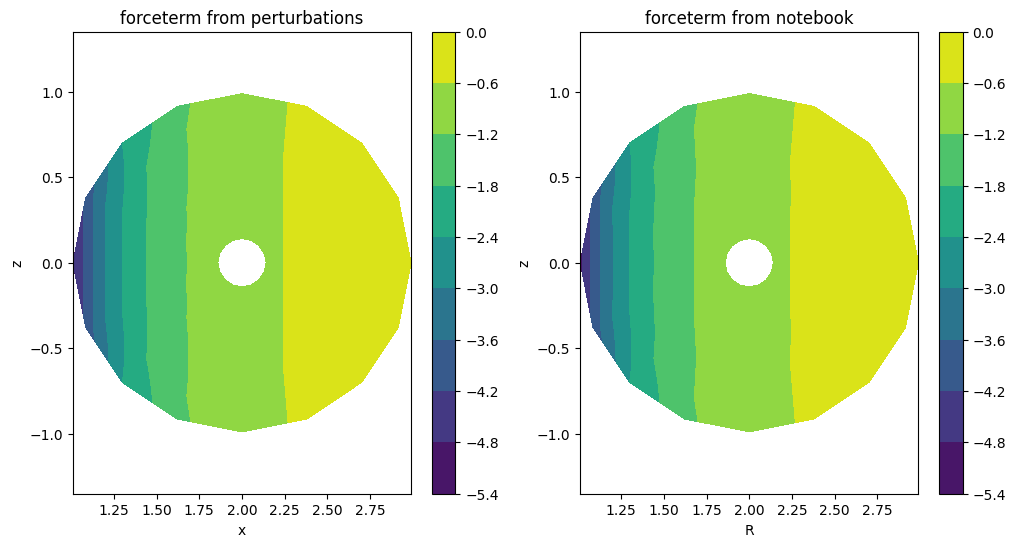

In [116]:
from struphy.initial import perturbations
_fun = getattr(perturbations, "forcingterm")(nu=1.0, R0=2.0, a=1.0, B0=10.0, Bp=12.5, alpha=0.1, beta=1.0)


def force(R, z):
        force_Z = 1.0 * (0.1 * (2.0 - 4 * R) / (
            2.0 * R
        ) - 1.0 * 12.5 * 2.0**2 / (10.0 * 1.0 * R**3))
        
        return force_Z

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], _fun(x_grid[:, :, 0], y_grid[:, :, 0], z_grid[:, :, 0]))
plt.colorbar()
plt.title(f'forceterm from perturbations')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], force(R_grid[:, :, 0], z_grid[:, :, 0]))
plt.colorbar()
plt.title(f'forceterm from notebook')
plt.xlabel('R')
plt.ylabel('z')
plt.axis('equal')

## Analytic solution

Comparison of implementation in notebook and in perturbations

(1.0100505063388328,
 2.9899494936611677,
 -0.9899494936611669,
 0.9899494936611669)

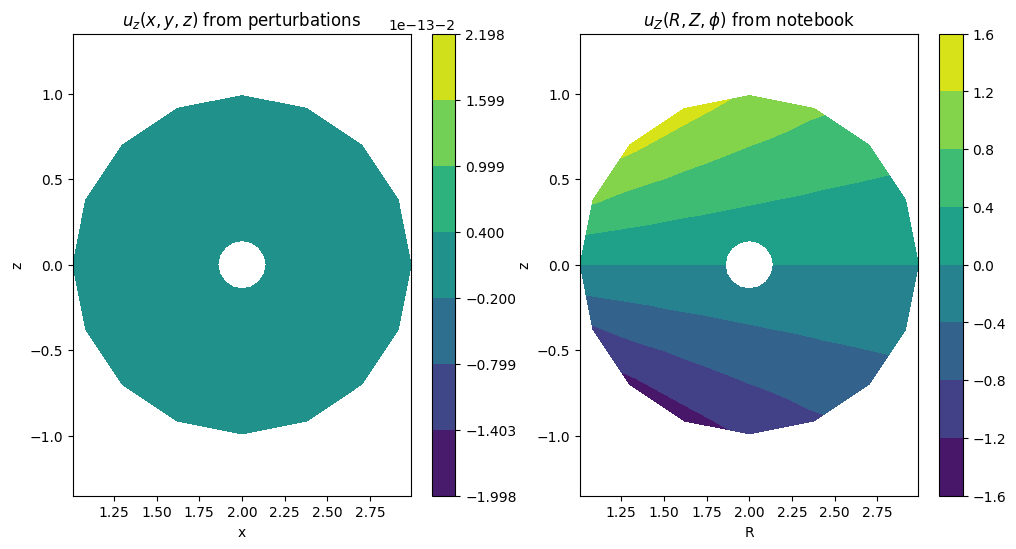

In [ ]:
from struphy.initial import perturbations
_analytic_u_x = getattr(perturbations, "AnalyticSolutionRestelliVelocity_x")()
_analytic_u_y = getattr(perturbations, "AnalyticSolutionRestelliVelocity_y")()
_analytic_u_z = getattr(perturbations, "AnalyticSolutionRestelliVelocity_z")()
_analytic_potential = getattr(perturbations, "AnalyticSolutionRestelliPotential")()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], _analytic_u_y(x_grid[:, :, 0], y_grid[:, :, 0], z_grid[:, :, 0]))
plt.colorbar()
plt.title(f'$u_z(x,y,z)$ from perturbations')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], uanalyt[0][:, :, 0])
plt.colorbar()
plt.title(f'$u_Z(R,Z,\phi)$ from notebook')
plt.xlabel('R')
plt.ylabel('z')
plt.axis('equal')

(1.0100505063388328,
 2.9899494936611677,
 -0.941494485015407,
 0.9414944850154074)

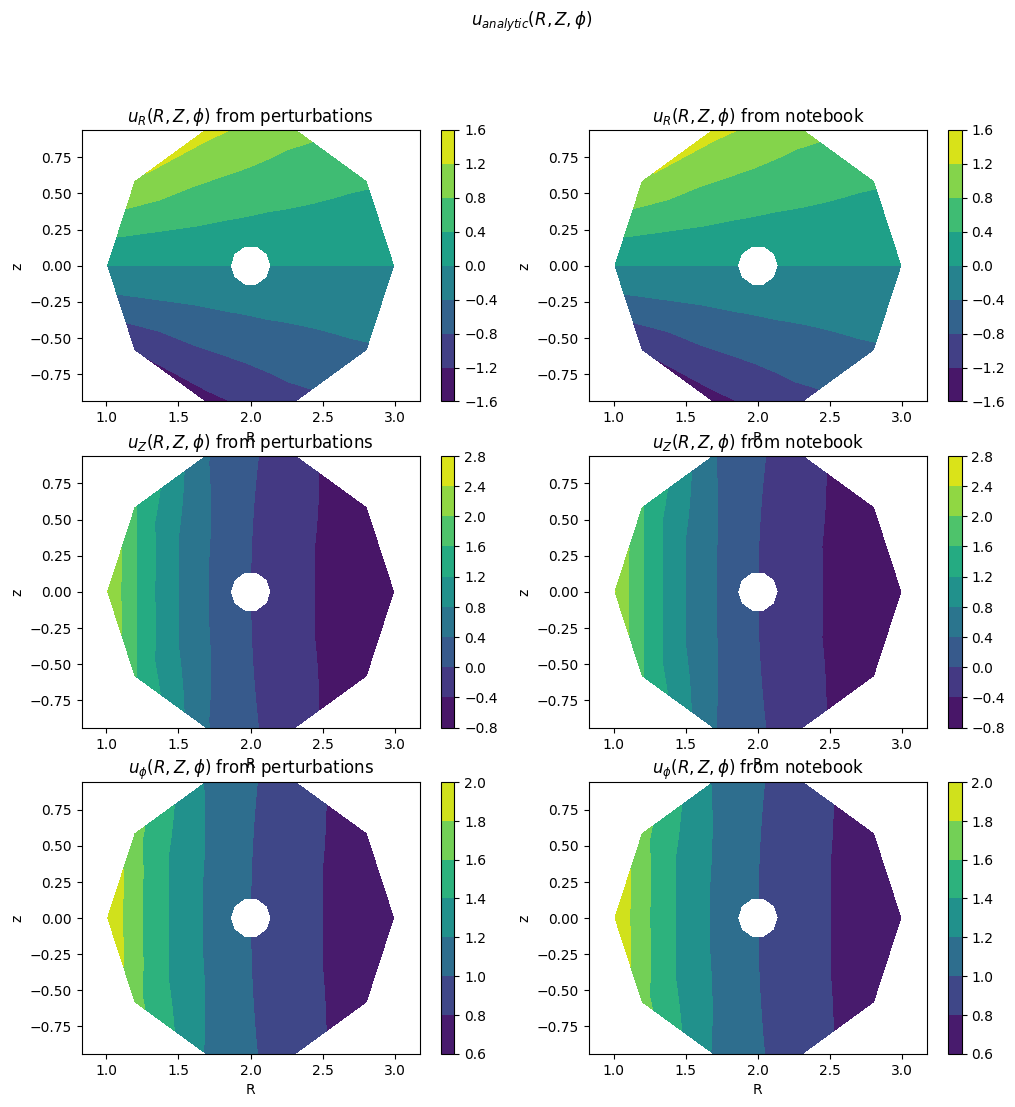

In [ ]:
_transformed_R = _analytic_u_x(x_grid, y_grid, z_grid)*np.cos(phi_grid) - _analytic_u_y(x_grid, y_grid, z_grid)*np.sin(phi_grid)
_transformed_Z = _analytic_u_z(x_grid, y_grid, z_grid)
_transformed_phi = -1/R_grid*_analytic_u_x(x_grid, y_grid, z_grid)*np.sin(phi_grid) - 1/R_grid*_analytic_u_y(x_grid, y_grid, z_grid)*np.cos(phi_grid)

plt.figure(figsize=(12, 12))
plt.suptitle('$u_{analytic}(R,Z,\phi)$')

plt.subplot(3, 2, 1)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], _transformed_R[:,:,0])
plt.colorbar()
plt.title(f'$u_R(R,Z,\phi)$ from perturbations')
plt.xlabel('R')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 2)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], uanalyt[0][:, :, 0])
plt.colorbar()
plt.title(f'$u_R(R,Z,\phi)$ from notebook')
plt.xlabel('R')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 3)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], _transformed_Z[:,:,0])
plt.colorbar()
plt.title(f'$u_Z(R,Z,\phi)$ from perturbations')
plt.xlabel('R')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 4)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], uanalyt[1][:, :, 0])
plt.colorbar()
plt.title(f'$u_Z(R,Z,\phi)$ from notebook')
plt.xlabel('R')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 5)
plt.contourf(R_grid[:, :, 0], z_grid[:, :, 0], _transformed_phi[:,:,0])
plt.colorbar()
plt.title(f'$u_\phi(R,Z,\phi)$ from perturbations')
plt.xlabel('R')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 6)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], uanalyt[2][:, :, 0])
plt.colorbar()
plt.title(f'$u_\phi(R,Z,\phi)$ from notebook')
plt.xlabel('R')
plt.ylabel('z')
plt.axis('equal')

## Transformation of $u_{analyt}(R, Z, \phi)$ into $u_{analyt}(x,y,z)$

(1.0100505063388328,
 2.9899494936611677,
 -0.941494485015407,
 0.9414944850154074)

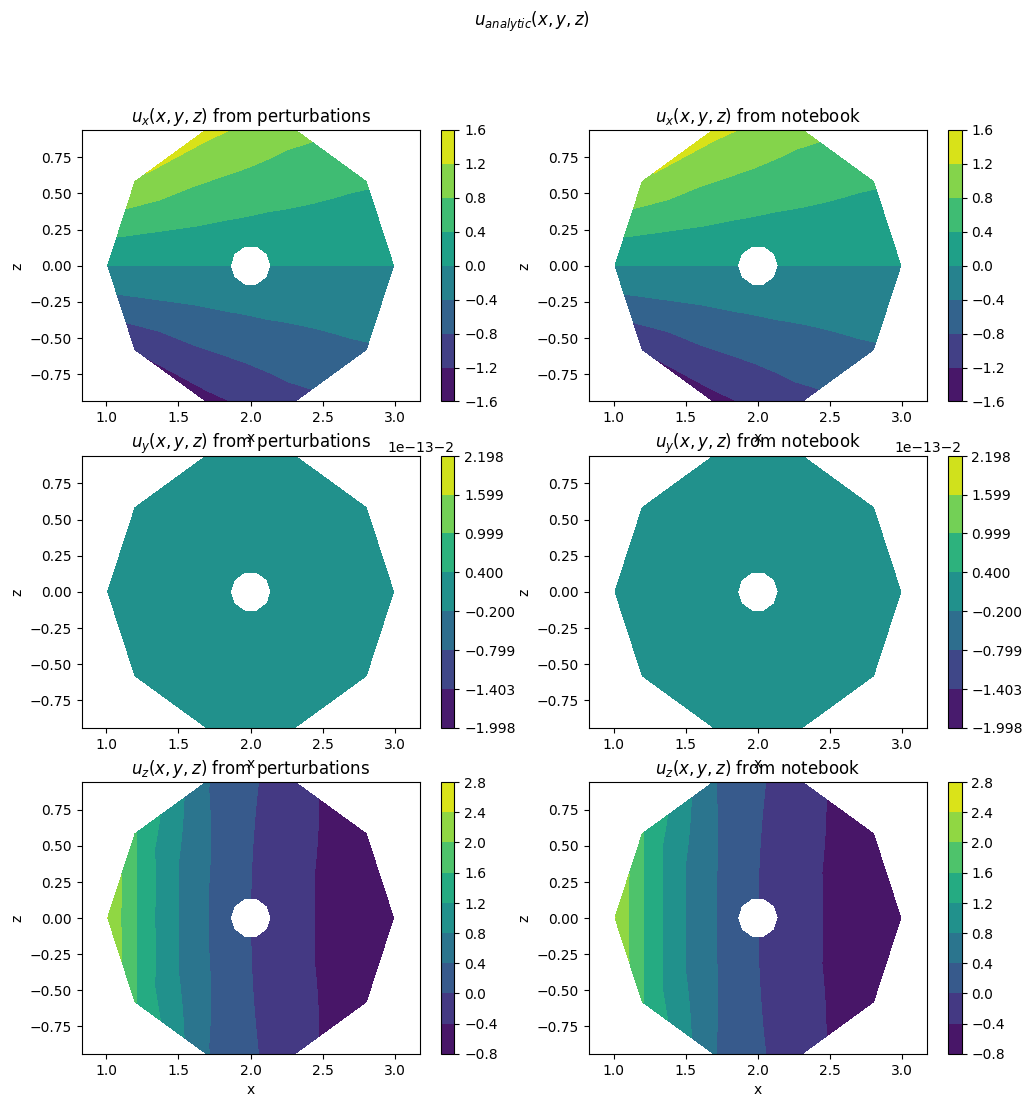

In [ ]:
uanalyt_x = np.cos(phi_grid)*uanalyt[0] - R_grid*np.sin(phi_grid)*uanalyt[2]
uanalyt_y = -np.sin(phi_grid)*uanalyt[0] - R_grid*np.cos(phi_grid)*uanalyt[2]
uanalyt_z = uanalyt[1]

u_analyt_xyz = [uanalyt_x, uanalyt_y, uanalyt_z]
plt.figure(figsize=(12, 12))
plt.suptitle('$u_{analytic}(x,y,z)$')

plt.subplot(3, 2, 1)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], _analytic_u_x(x_grid[:, :, 0], y_grid[:, :, 0], z_grid[:, :, 0]))
plt.colorbar()
plt.title(f'$u_x(x,y,z)$ from perturbations')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 2)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], u_analyt_xyz[0][:, :, 0])
plt.colorbar()
plt.title(f'$u_x(x,y,z)$ from notebook')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 3)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], _analytic_u_y(x_grid[:, :, 0], y_grid[:, :, 0], z_grid[:, :, 0]))
plt.colorbar()
plt.title(f'$u_y(x,y,z)$ from perturbations')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 4)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], u_analyt_xyz[1][:, :, 0])
plt.colorbar()
plt.title(f'$u_y(x,y,z)$ from notebook')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 5)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], _analytic_u_z(x_grid[:, :, 0], y_grid[:, :, 0], z_grid[:, :, 0]))
plt.colorbar()
plt.title(f'$u_z(x,y,z)$ from perturbations')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')

plt.subplot(3, 2, 6)
plt.contourf(x_grid[:, :, 0], z_grid[:, :, 0], u_analyt_xyz[2][:, :, 0])
plt.colorbar()
plt.title(f'$u_z(x,y,z)$ from notebook')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')